# custom model one - with augmentation


## Context
The data consists of images of 23 types of skin diseases taken from http://www.dermnet.com/dermatology-pictures-skin-disease-pictures. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Libraries

In [2]:
import datetime
import operator
##open cv
import cv2
from google.colab.patches import cv2_imshow
import random
#numpy-pandas
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#tensorflow and utilities
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import regularizers

#tensorflow model, layers, optimizers etc
from tensorflow.keras import Input 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, concatenate, AveragePooling2D, GlobalAveragePooling2D

#callbacks
from tensorflow.keras.callbacks import BaseLogger, CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ReduceLROnPlateau

#pretrained models
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import  preprocess_input
from tensorflow.keras.applications.resnet import  preprocess_input

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

## 2. Import Data

In [3]:
#getting dataframes of train and test data
train_df = pd.read_csv("/content/drive/MyDrive/Dermnet/Files/final_dataframe/final_train_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Dermnet/Files/final_dataframe/final_test_df.csv")

In [4]:
train_df["path"] = train_df["class"] + "/" + train_df["image_name"]
test_df["path"] = test_df["class"] + "/" + test_df["image_name"]

print("Shape of train dataset is {}.".format(train_df.shape))
print("Shape of test dataset is {}.".format(test_df.shape))

Shape of train dataset is (14523, 4).
Shape of test dataset is (3527, 4).


In [5]:
train_df["class"].value_counts()

Seborrheic Keratoses and other Benign Tumors                          1350
Psoriasis pictures Lichen Planus and related diseases                 1297
Eczema Photos                                                         1222
Tinea Ringworm Candidiasis and other Fungal Infections                1218
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions    1118
Warts Molluscum and other Viral Infections                             985
Nail Fungus and other Nail Disease                                     855
Systemic Disease                                                       568
Acne and Rosacea Photos                                                561
Light Diseases and Disorders of Pigmentation                           546
Atopic Dermatitis Photos                                               485
Vascular Tumors                                                        482
Melanoma Skin Cancer Nevi and Moles                                    456
Bullous Disease Photos   

In [6]:
test_df["class"].value_counts()

Psoriasis pictures Lichen Planus and related diseases                 339
Seborrheic Keratoses and other Benign Tumors                          339
Tinea Ringworm Candidiasis and other Fungal Infections                309
Eczema Photos                                                         300
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions    283
Warts Molluscum and other Viral Infections                            247
Nail Fungus and other Nail Disease                                    210
Systemic Disease                                                      143
Light Diseases and Disorders of Pigmentation                          137
Vascular Tumors                                                       121
Atopic Dermatitis Photos                                              120
Melanoma Skin Cancer Nevi and Moles                                   115
Bullous Disease Photos                                                113
Vasculitis Photos                     

## 3. Class Selection

* The classes selected below are based on the distinctive nature of them. Classes are:
    * Hair Loss Photos Alopecia and other Hair Diseases
    * Herpes HPV and other STDs Photos
    * Melanoma Skin Cancer Nevi and Moles
    * Nail Fungus and other Nail Disease
    * Urticaria Hives

In [7]:
class_to_keep = ["Herpes HPV and other STDs Photos", "Melanoma Skin Cancer Nevi and Moles", "Hair Loss Photos Alopecia and other Hair Diseases", "Urticaria Hives"]
train_df_m1 = train_df[train_df["class"].isin(class_to_keep)]
test_df_m1 = test_df[test_df["class"].isin(class_to_keep)]

#getting only 500 images of nail fungus
train_df_m2 = train_df[train_df["class"] == "Nail Fungus and other Nail Disease"].iloc[0:500,:]
test_df_m2 = test_df[test_df["class"] == "Nail Fungus and other Nail Disease"].iloc[0:500,:]

merged_train_df = pd.concat([train_df_m1, train_df_m2])
merged_test_df = pd.concat([test_df_m1, test_df_m2])

#getting the values counts
merged_train_df["class"].value_counts()

Nail Fungus and other Nail Disease                   500
Melanoma Skin Cancer Nevi and Moles                  456
Herpes HPV and other STDs Photos                     382
Hair Loss Photos Alopecia and other Hair Diseases    212
Urticaria Hives                                      212
Name: class, dtype: int64

### 3.1 train-test split

In [8]:
train_df_final, validation_df_final = train_test_split(merged_train_df, test_size=0.20)
print("Shape of train : {}.".format(train_df_final.shape))
print("Shape of test : {}.".format(validation_df_final.shape))

Shape of train : (1409, 4).
Shape of test : (353, 4).


In [9]:
merged_test_df["class_cat"] = merged_test_df["class"].astype('category').cat.codes
y_true = merged_test_df["class_cat"].values

## 4. Image Pipeline

In [10]:
channels = 3
batchsize = 32
num_classes = 5
img_rows = 256
img_cols = 256 


# creating a pipeline for image augmentation using imagedatagenerator
datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=30,
                            shear_range=0.3,
                            zoom_range=0.5,
                            width_shift_range=0.4,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            brightness_range=(0.2,0.5),
                            fill_mode='nearest')

In [11]:
#Train Generator
train_generator=datagen.flow_from_dataframe(dataframe = train_df_final, 
                                            directory="/content/drive/MyDrive/Dermnet/Images/train/", 
                                            x_col="path", 
                                            y_col="class", 
                                            class_mode="categorical",
                                            subset="training",
                                            shuffle=True,
                                            target_size=(img_rows, img_cols),
                                            batch_size = batchsize,
                                            color_mode='rgb',
                                            seed=42)

Found 1409 validated image filenames belonging to 5 classes.


In [12]:
#Validation Generator
valid_generator=datagen.flow_from_dataframe(dataframe = validation_df_final, 
                                            directory="/content/drive/MyDrive/Dermnet/Images/train/", 
                                            x_col="path", 
                                            y_col="class", 
                                            class_mode="categorical",
                                            subset="training",
                                            shuffle=True,
                                            target_size=(img_rows, img_cols),
                                            batch_size = batchsize,
                                            color_mode='rgb',
                                            seed=42)

Found 353 validated image filenames belonging to 5 classes.


## 5. Callbacks and functions

In [13]:
#Loading TensorBoard
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

In [14]:
#rensorboard
log_dir = "/content/drive/MyDrive/Dermnet/callbacks/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
board = TensorBoard(log_dir = log_dir,
                    histogram_freq=1,
                    write_graph=True,
                    write_grads=False)

#reduce learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=2,
                             min_lr=0.001)

In [15]:
def loss_plot(train_loss, test_loss, total_epoch):
    """
    This function plots the loss graph of both train and validation dataset.
    """
    fig = plt.figure(figsize=(15,5))  #setting up figure size
    plt.plot(train_loss);  plt.plot(test_loss)
    #setting up ticks
    plt.xticks(range(1,total_epoch))
    plt.legend(["Train_Loss", "Validation_Loss"])
    #setting up labels
    plt.xlabel("Number of Epochs", fontsize=10)
    plt.ylabel("Log Loss", fontsize=10)
    plt.title("Loss Plot for train and validation dataset", fontsize=20)
    return plt.show()



def accuracy_plot(train_accuracy, test_accuracy, total_epoch):
    """
    This function plots the accuracy graph of both train and validation dataset.
    """
    fig = plt.figure(figsize=(15,5))  #setting up figure size
    plt.plot(train_accuracy);  plt.plot(test_accuracy)
    #setting up ticks
    plt.xticks(range(1,total_epoch))
    plt.legend(["Train_Accuracy", "Validation_Accuracy"])
    #setting up labels
    plt.xlabel("Number of Epochs", fontsize=10)
    plt.ylabel("Accuracy", fontsize=10)
    plt.title("Accuracy Plot for train and validation dataset", fontsize=20)
    return plt.show()


## 6. Custom Model one with Augmentation

In [16]:
def create_model(img_rows, img_cols, channels, nb_train_samples, num_classes):
    """
    This function use 2 convolutional layers with below configuration to train the model.
        Padding = valid; Stride = (1,1); kernel = (3,3)
    input:
    ------
        img_rows           : width of the image
        img_cols           : height of the image
        channels           : rgb(3), grayscale(1)
        nb_train_samples   : number of training samples
        num_classes        : number of classes to be trained
    output:
    -------
        model setup
    """
    clear_session()
    #creating sequential model
    model = Sequential()
    #adding conv layer with relu activation
    model.add(Conv2D(32,(3,3), input_shape=(img_rows, img_cols, channels)))
    model.add(Activation('relu'))

    #adding anonther conv layer with relu activation
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))

    #maxpooing
    model.add(MaxPooling2D(pool_size=(2,2)))

    #flattening the model
    model.add(Flatten())

    #Dense layer with number of training samples as neurons
    model.add(Dense(nb_train_samples))
    model.add(Activation('relu'))

    #softmax layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

## 7. Compilation and Training

In [17]:
epochs= 10
nb_train_samples = 1409
nb_validation_samples = 353

In [18]:
# model function call
model = create_model(img_rows,img_cols,channels,nb_train_samples, num_classes)

#compilation of model
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], 
              optimizer=Adam(0.001))

In [19]:
# fitting model
history = model.fit(train_generator, steps_per_epoch = nb_train_samples//batchsize, epochs=epochs, 
                    validation_data=valid_generator,
                    validation_steps=nb_validation_samples//batchsize,
                    callbacks = [reduceLR])

Epoch 1/10
44/44 [==============================] - 63s 1s/step - loss: 11.6801 - accuracy: 0.2027 - val_loss: 1.4576 - val_accuracy: 0.4205
Epoch 2/10
44/44 [==============================] - 45s 1s/step - loss: 1.4734 - accuracy: 0.4281 - val_loss: 1.3892 - val_accuracy: 0.5000
Epoch 3/10
44/44 [==============================] - 43s 973ms/step - loss: 1.3904 - accuracy: 0.4555 - val_loss: 1.3713 - val_accuracy: 0.4602
Epoch 4/10
44/44 [==============================] - 42s 954ms/step - loss: 1.3175 - accuracy: 0.4758 - val_loss: 1.3158 - val_accuracy: 0.4688
Epoch 5/10
44/44 [==============================] - 46s 1s/step - loss: 1.3353 - accuracy: 0.4751 - val_loss: 1.2739 - val_accuracy: 0.4574
Epoch 6/10
44/44 [==============================] - 47s 1s/step - loss: 1.2846 - accuracy: 0.4596 - val_loss: 1.2012 - val_accuracy: 0.5369
Epoch 7/10
44/44 [==============================] - 48s 1s/step - loss: 1.2486 - accuracy: 0.4893 - val_loss: 1.2077 - val_accuracy: 0.5455
Epoch 8/10
44

## 8. Save Model

In [20]:
model.save('/content/drive/MyDrive/Dermnet/SavedModels/expeiment2.h5')  # creates a HDF5 file 

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 508032)            0         
_________________________________________________________________
dense (Dense)                (None, 1409)              7

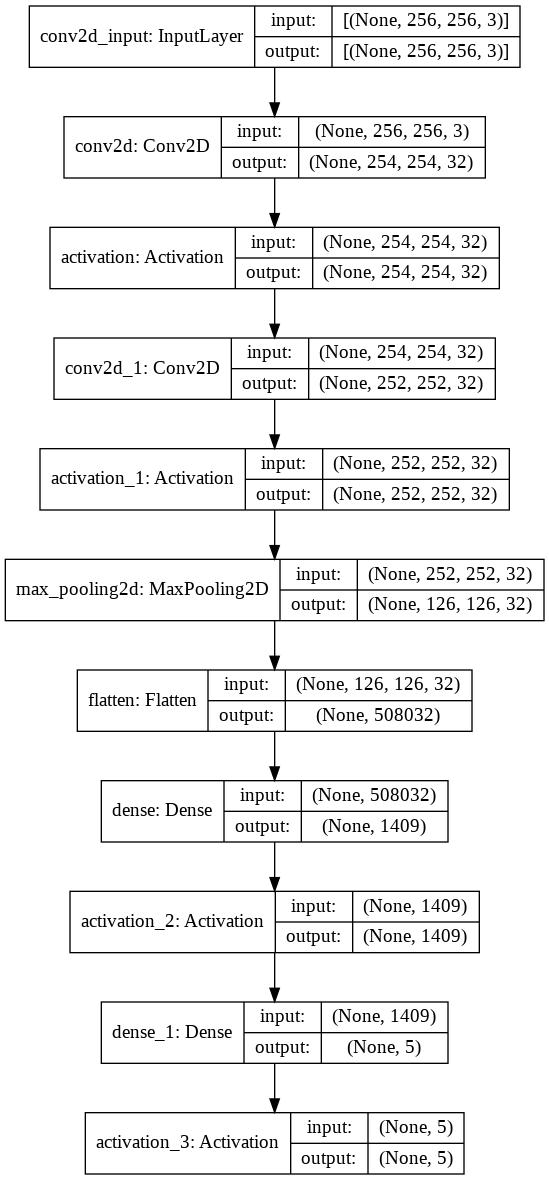

In [22]:
tf.keras.utils.plot_model(model, to_file="experiment2.jpg", show_shapes=True)

## 9. Loss and Accuracy Plot

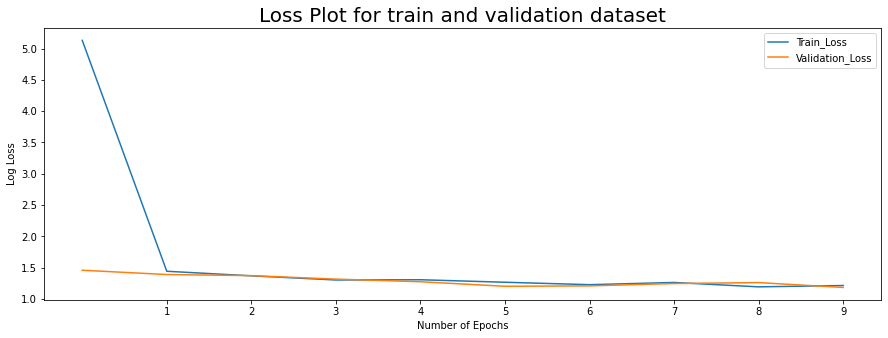

In [28]:
loss_plot(history.history["loss"], history.history["val_loss"], 10)

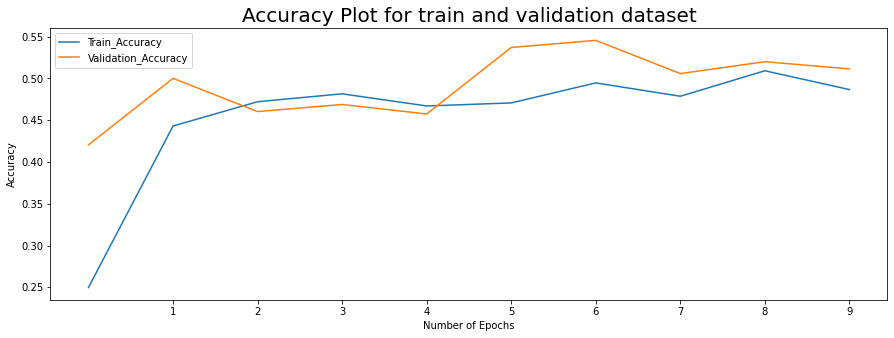

In [29]:
accuracy_plot(history.history["accuracy"], history.history["val_accuracy"], 10)

## 10.Prediction

In [26]:
### test generator for prediction of output images
test_generator = datagen.flow_from_dataframe(dataframe = merged_test_df, 
                                            directory="/content/drive/MyDrive/Dermnet/Images/test/", 
                                            x_col="path", 
                                            y_col=None, 
                                            class_mode=None,
                                            subset=None,
                                            shuffle=False,
                                            target_size=(img_rows, img_cols),
                                            batch_size = batchsize,
                                            color_mode='rgb')

#predicting all values
output_scores = model.predict_generator(test_generator)

Found 510 validated image filenames.


## 12. Evaluation Metric

              precision    recall  f1-score   support

           0       0.37      0.65      0.47        46
           1       0.43      0.07      0.12        86
           2       0.41      0.74      0.53       115
           3       0.72      0.72      0.72       210
           4       0.00      0.00      0.00        53

    accuracy                           0.53       510
   macro avg       0.39      0.44      0.37       510
weighted avg       0.50      0.53      0.48       510



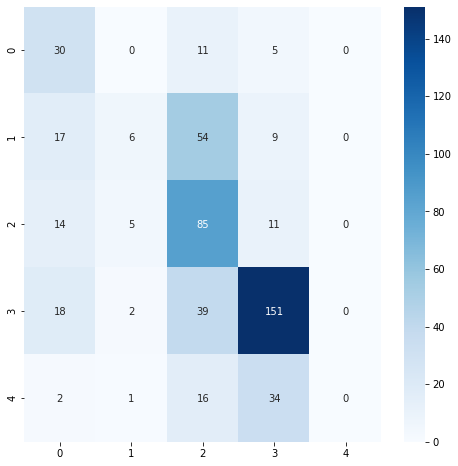

In [27]:
#getting output scores
class_outputs = [max(enumerate(val), key=operator.itemgetter(1)) for val in output_scores]
#getting prediction values
y_pred = [val[0] for val in class_outputs]


#getting confusion metrix
conf_matrix = confusion_matrix(y_true, y_pred)


#getting classification report 
print(classification_report(y_true, y_pred))


fig = plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, cmap ="Blues", fmt="d")